$\begin{align*}
(V,E) &:   \text{ undirected graph G} \\
V(G) &:  \text{set of vertices of graph G}\\ 
E(G) &:  \text{set of edges of graph G} \\
N(v) &: \{u \in V : (u,v) \in E\} \\
\mathcal{L} &: \text{label set} \\
\ell &: \text{Labelling function} \\
(V,E,\ell) &: \text{labeled or attributed graph} \\   
\varphi &: \text{Graph Isomorphism between labeled graphs}\\
\psi_{\varphi} &:  \text{vertex paris implicated by the bijection } \psi_{\varphi}: V_{1} \times V_{1} \rightarrow V_{2} \times V_{2} , \psi_{\varphi}((u,v)) = (\varphi(u), \varphi(v)) \\
G_1 \approx G_2 &: \text{Isomporpsim} \\
\text{Aut}(G) &: \text{isomorphism onto itself} \\
\varphi &: \text{common subgraph isomorphism (CSI)}\\
k_{\text{cal}}(G_1,G_2) &: \text{common subgraph isomorphism (CSI) kernel}\\
k_{\text{sm}}(G_1,G_2)  &: \text{Subgraph Matching Kernel}
\end{align*}$

$\textbf{Theorem 1}$: The subgraph matching kernel is p.s.d

The structure of a graph $G = (V,E)$ with $n$ vertices can be encoded by tuple $(v,\textbf{e})$ where $v = (v_{i})_{n}$ is a sequence of vertices in $V$ and $\textbf{e} = [e_{i,j}]_{n \times n}$ is a matrix of elements $E \cup \{e\}$, s.t $e_{i,j} = (v_i,v_j)$ if $(v_i,v_j) \in E$ and $\epsilon$ otherwise. By extending $v$ and $\textbf{e}$ by additional  $\epsilon$-elements we can encode graphs of different size into the same space.  Each permutation of the vertices of a graph yields a valid encoding and a graph can be decomposed into all its encodings. This allows us to define a graph kernel by specifying an R-convolution. let $\text{R}(v,e,G)$ be relation, where $v$ and $\textbf{}$

we can identify Def.2 as a speical case of Def.3 where 

\textbf{Kernel Computation}



In [ ]:
#install python-igraph : we use IGraph for manipulating and storing graph data
#install cairocffi : needed for ploting for python-igraph

!pip install python-igraph
!pip install cairocffi

     |████████████████████████████████| 3.2MB 7.0MB/s 
     |████████████████████████████████| 71kB 3.9MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=3717c8884044cd8428cb7dc50ea4f88fc37986d415c701c8d32f06d387278e14
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


In [ ]:
import os
import platform
import numpy as np
import igraph as ig
from tqdm import tqdm
from sklearn.svm import SVC
import multiprocessing as mp
from numpy import linalg as LA
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from IPython.core.display import display, Image
from itertools import combinations,combinations_with_replacement

In [ ]:
print("Python Version: ", platform.python_version())
print("Number of processors: ", mp.cpu_count())

Python Version:  3.7.10
Number of processors:  2


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
path = 'data/graph_data'

Mounted at /content/drive


In [ ]:
#retreving the file names

def get_data(path):
  graph_files = []
  for file in os.listdir(path):
    if file.endswith('gml'):
        graph_files.append(os.path.join(path,file))
  graph_files.sort()
  return graph_files
  

In [ ]:
# making sure that multiple igraph plots are shown in single jupyter cell

def plot(G,id,plt_dims=(200,200)):
  print("Graph "+id,end= "\n\n")
  ig.plot(G,bbox = plt_dims).save('temporary.png') 
  display(Image(filename='temporary.png'))
  os.remove('temporary.png')

Graph G1



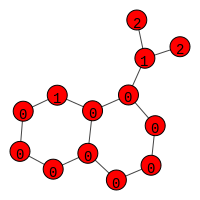

Graph G2



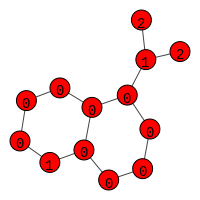

In [ ]:
#sample graph visualization

mutang_path = '/content/drive/MyDrive/data/graph_data/MUTAG'
graph_files = get_data(path)
G0 = ig.read(graph_files[1])
G1 = ig.read(graph_files[2])
plot(G0,"G1")
plot(G1,"G2")

In [ ]:
#read all .gml files as Igraph objects

def get_Gs(path):
  graph_files = get_data(path)
  Gs = []
  for graph_file in tqdm(graph_files):
    g = ig.read(graph_file)
    Gs.append(g)
  return Gs  



In [ ]:
#scan through all graphs and find total number of unique labels

def get_sizeof_L(graphs):
  """
  Parameters 
  graphs : list of Igraph objects
  Returns 
  sizeof_L : int 
  """

  n_Gs = len(graphs)
  G_node_labels = list()
  for g in graphs:
    g_node_labels = g.vs['label']
    G_node_labels.extend(g_node_labels)
  sizeof_L = len(set(G_node_labels))
  return sizeof_L  



In [ ]:
mutang_path = '/content/drive/MyDrive/data/graph_data/MUTAG'
Gs = get_Gs(mutang_path)
sizeof_L = get_sizeof_L(Gs)
print(" Number of unique labels : ",sizeof_L)

100%|██████████| 188/188 [01:02<00:00,  3.02it/s]

 Number of unique labels :  7


In [ ]:
def modular_product_graph(g1,g2):

  product_graph = ig.Graph()
  for v1 in g1.vs:
    for v2 in g2.vs:
      if v1['label'] == v2['label']:
        product_graph.add_vertex(id=(v1['id'],v2['id']), label=v1['label'],pair=(v1,v2) )

  N_gs = product_graph.vcount()
  print("number of vertices in the product graph", N_gs)
  for i,j in tqdm(combinations_with_replacement(range(N_gs),2)):
    pg_v1 = product_graph.vs[i]
    pg_v2 = product_graph.vs[j]

    u1 = product_graph.vs[i]['pair'][0]
    v1 = product_graph.vs[j]['pair'][0]
    u2 = product_graph.vs[i]['pair'][1]
    v2 = product_graph.vs[j]['pair'][1]

    #check for different edges

    if (u1 != v1 and u2 != v2):
      edge1 = g1.get_eid(u1, u2, directed=False, error=False)
      edge2  = g2.get_eid(v1, v2, directed=False, error=False)
      if (edge1 != -1 and edge2 != -1):
        if (edge1['weight'] == edge2['weight']):
          product_graph.add_edge(i,j, weight=edge1['weight'])
      else if (edge1 == -1 and edge2 == -1):
        product_graph.add_edge(i,j, weight=edge1['weight'])


    return product_graph    



3916it [00:00, 33060.58it/s]

number of verts 89
Graph product



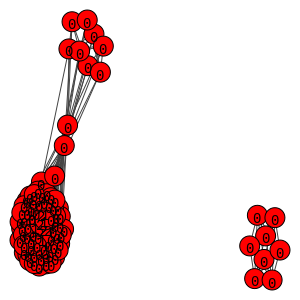

edge count 2154


In [ ]:
product_graph = ig.Graph()
for v1 in G0.vs:
  for v2 in G1.vs:
    if v1['label'] == v2['label']:
      product_graph.add_vertex(id=(v1['id'],v2['id']), label=v1['label'],pair=(v1,v2) )


N_gs = product_graph.vcount()
print("number of verts" , N_gs)
count = 0
for i,j in tqdm(combinations(range(N_gs),2)):
  pg_v1 = product_graph.vs[i]
  pg_v2 = product_graph.vs[j]

  u1 = product_graph.vs[i]['pair'][0]
  v1 = product_graph.vs[j]['pair'][0]

  u2 = product_graph.vs[i]['pair'][1]
  v2 = product_graph.vs[j]['pair'][1]

  #check for different edges

  if (u1 != v1 and u2 != v2):
    edge1 = G0.get_eid(u1, u2, directed=False, error=False)
    edge2  = G1.get_eid(v1, v2, directed=False, error=False)
   
    if (edge1 != -1 and edge2 != -1):
      e1 = G0.es[edge1]
      e2 = G1.es[edge2]
      
      if (e1['weight'] == e2['weight']):
        product_graph.add_edge(i,j)
    elif (edge1 == -1 and edge2 == -1):
      product_graph.add_edge(i,j)


plot(product_graph,"product",plt_dims=(300,300))
print("edge count", product_graph.ecount())